In [ ]:
!pip install tflite-model-maker

In [2]:
!pip install tensorflow==2.4

In [3]:
import numpy as np
import tensorflow as tf
assert tf.__version__.startswith('2')
from tflite_model_maker import configs
from tflite_model_maker import ExportFormat
from tflite_model_maker import image_classifier
from tflite_model_maker import ImageClassifierDataLoader
from tflite_model_maker import model_spec
import matplotlib.pyplot as plt

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
%cd /content/drive/MyDrive/MIP/models/obj

/content/drive/MyDrive/MIP/models/obj


In [6]:
import numpy as np
import os
import matplotlib.pyplot as plt
import shutil
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras import regularizers
from keras.optimizers import Adam,SGD

In [33]:
# !tar -xvf  '101_ObjectCategories.tar'

In [ ]:
for i in os.listdir('101_ObjectCategories'):
  print(i)

In [35]:
# shutil.rmtree('./101_ObjectCategories/BACKGROUND_Google')

In [36]:
# shutil.rmtree('./101_ObjectCategories/Faces_easy')

In [13]:
len(os.listdir('101_ObjectCategories'))

100

In [14]:
classes = {}
for i in os.listdir('./101_ObjectCategories'):
    ct = 0
    for j in os.listdir(f'./101_ObjectCategories/{i}'):
        ct += 1
    classes[i] = ct

In [15]:
len(classes)

100

<BarContainer object of 100 artists>

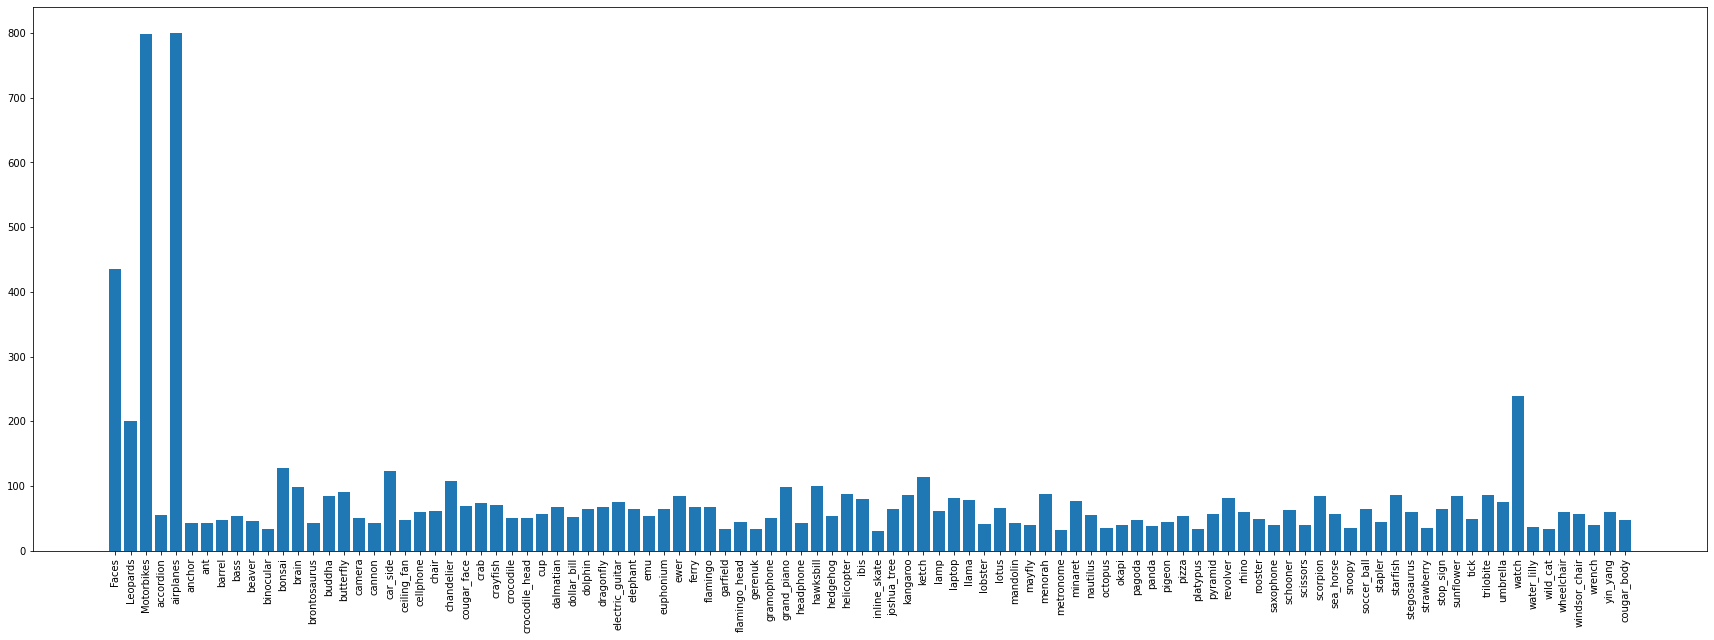

In [16]:
plt.figure(figsize = (30, 10))
plt.xticks(rotation=90)
plt.bar(list(classes.keys()), list(classes.values()))

In [18]:
from keras.applications.inception_v3 import InceptionV3

In [20]:
datagen = ImageDataGenerator(validation_split=0.25, rescale = 1./255)

train_generator = datagen.flow_from_directory(
    './101_ObjectCategories/', 
    subset = 'training',
    target_size = (128, 128),
    batch_size =32,
    class_mode = 'categorical',
    classes = list(classes.keys())
)

val_generator = datagen.flow_from_directory(
    './101_ObjectCategories/',
    subset='validation',
    target_size = (128, 128),
    batch_size =32,
    class_mode = 'categorical',
    classes = list(classes.keys())
)

Found 6225 images belonging to 100 classes.
Found 2017 images belonging to 100 classes.


# Inception Network


In [24]:
model = Sequential()
model.add(InceptionV3(weights='imagenet', include_top=False))
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(100, activation='softmax'))

In [25]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [ ]:
x = model.fit(train_generator, epochs=10,validation_data=val_generator)

In [ ]:
plt.figure(figsize=(12, 6), dpi=80)
plt.subplot(1, 2, 1)
plt.plot(x.history['accuracy'])
plt.plot(x.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.plot()

plt.subplot(1, 2, 2)
plt.plot(x.history['loss']) 
plt.plot(x.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.plot()
plt.show()

In [ ]:
model.save("inception_caltech.h5")

In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('inception_caltech.tflite', 'wb') as f:
  f.write(tflite_model)

# TFlite model

In [17]:
data = ImageClassifierDataLoader.from_folder("./101_ObjectCategories")
train_data, test_data = data.split(0.75)

INFO:tensorflow:Load image with size: 8242, num_label: 100, labels: Faces, Leopards, Motorbikes, accordion, airplanes, anchor, ant, barrel, bass, beaver, binocular, bonsai, brain, brontosaurus, buddha, butterfly, camera, cannon, car_side, ceiling_fan, cellphone, chair, chandelier, cougar_body, cougar_face, crab, crayfish, crocodile, crocodile_head, cup, dalmatian, dollar_bill, dolphin, dragonfly, electric_guitar, elephant, emu, euphonium, ewer, ferry, flamingo, flamingo_head, garfield, gerenuk, gramophone, grand_piano, hawksbill, headphone, hedgehog, helicopter, ibis, inline_skate, joshua_tree, kangaroo, ketch, lamp, laptop, llama, lobster, lotus, mandolin, mayfly, menorah, metronome, minaret, nautilus, octopus, okapi, pagoda, panda, pigeon, pizza, platypus, pyramid, revolver, rhino, rooster, saxophone, schooner, scissors, scorpion, sea_horse, snoopy, soccer_ball, stapler, starfish, stegosaurus, stop_sign, strawberry, sunflower, tick, trilobite, umbrella, watch, water_lilly, wheelchair

In [27]:
train_data, rest_data = data.split(0.8)
validation_data, test_data = rest_data.split(0.5)

In [28]:
model = image_classifier.create(train_data, model_spec=model_spec.resnet_50_spec, validation_data=validation_data,epochs=10)

INFO:tensorflow:Retraining the models...
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hub_keras_layer_v1v2 (HubKer (None, 2048)              23564800  
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               204900    
Total params: 23,769,700
Trainable params: 204,900
Non-trainable params: 23,564,800
_________________________________________________________________
None
Epoch 1/10
206/206 [==============================] - 51s 228ms/step - loss: 2.6201 - accuracy: 0.5962 - val_loss: 1.2162 - val_accuracy: 0.9100
Epoch 2/10
206/206 [==============================] - 46s 224ms/step - loss: 1.1727 - accuracy: 0.9358 - val_loss: 1.1683 - val_accuracy: 0.9162
Epoch 3/10
206/206 [==========

In [29]:
loss, accuracy = model.evaluate(test_data)

26/26 [==============================] - 16s 151ms/step - loss: 1.1131 - accuracy: 0.9164


In [31]:
model.export(export_dir='/content/drive/MyDrive/MIP/models/obj', export_format=ExportFormat.LABEL)

INFO:tensorflow:Saving labels in /content/drive/MyDrive/MIP/models/obj/labels.txt.


INFO:tensorflow:Saving labels in /content/drive/MyDrive/MIP/models/obj/labels.txt.


In [32]:
model.export(export_dir='/content/drive/MyDrive/MIP/models/obj')

INFO:tensorflow:Assets written to: /tmp/tmpa7jfsle_/assets


INFO:tensorflow:Assets written to: /tmp/tmpa7jfsle_/assets


INFO:tensorflow:Label file is inside the TFLite model with metadata.


INFO:tensorflow:Label file is inside the TFLite model with metadata.


INFO:tensorflow:Saving labels in /tmp/tmphqeebl_q/labels.txt.


INFO:tensorflow:Saving labels in /tmp/tmphqeebl_q/labels.txt.
